# Substructure hidden in HST mock imaging data

Requires:
- `lenstronomy` (v1.6.0 or above)
- `slitronomy` (**dev-pot** branch)

In [1]:
__author__ = 'aymgal'

%matplotlib inline
from IPython import display

import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')

import os
import sys
import copy
import tqdm
import time
import numpy as np
from matplotlib.colors import LogNorm
import astropy.io.fits as pf
from scipy import signal
from scipy import sparse
import findiff

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.LightModel.Profiles.starlets import SLIT_Starlets
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.Plots import lens_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util.solver_plotter import SolverPlotter
from slitronomy.Optimization import proximals
from slitronomy.Util.plot_util import nice_colorbar
from slitronomy.Util import util

from mask import ImageMask

SEED = 8
np.random.seed(SEED)

cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize negative pixels when in log scale

## Global parameters


In [2]:
subgrid_res_source = 3
perfect_seeing = True
parametric_ray_tracing = True

## Definitions of some practical functions

In [3]:
# shortcut function
def a2i(arr):
    return lenstro_util.array2image(arr)
def i2a(img):
    return lenstro_util.image2array(img)


def SDR(truth, model):
    """computes Source Distortion Ratio"""
    diff = truth - model
    return 10 * np.log10( np.linalg.norm(truth.flatten(), 2) / np.linalg.norm(diff.flatten(), 2) )

## Define image size, resolution, and noise-related properties

In [4]:
# data specifics
num_pix = 80  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
num_pix_source = int(num_pix*subgrid_res_source)

background_rms = 0.05  # background noise per pixel
exp_time = None  # exposure time in seconds, effectively for adding Poisson noise

psf_fwhm = 0.2  # full width half max of the gaussian PSF, in delta_pix units
psf_num_pix = 31  # PSF kernel size

## Create coordinate grids

In [5]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, inverse=False)

image_grid  = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0)
source_grid = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0, 
                          supersampling_factor=subgrid_res_source)

ra_grid, dec_grid = image_grid.coordinates_evaluate
ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

## Instanciate Data and PSF classes

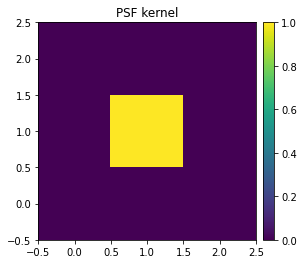

In [6]:
kwargs_data_empty = {
    'background_rms': background_rms,
    'ra_at_xy_0': ra_at_xy_0, 
    'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
if exp_time is not None: kwargs_data['exposure_time'] = exp_time
data_class_empty = ImageData(**kwargs_data_empty)

# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower', cmap='viridis')
nice_colorbar(im)
plt.show()

## Define a "complex" source surface brightness

In [7]:
# list of source light profiles
source_model_list = ['GAUSSIAN_ELLIPSE', 'GAUSSIAN_ELLIPSE']
kwargs_comp1 = {'amp': 70, 'sigma': 0.2, 'e1': 0.2, 'e2': 0.1, 'center_x': 0.2, 'center_y': 0.3}
kwargs_comp2 = {'amp': 35, 'sigma': 0.2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.3, 'center_y': -0.3}
kwargs_source = [kwargs_comp1, kwargs_comp2]

# create source model class
source_model_class = LightModel(light_model_list=source_model_list)

# compute average coordinates of the source position
source_center_x = (kwargs_comp1['center_x']+kwargs_comp2['center_x'])/len(source_model_list)
source_center_y = (kwargs_comp1['center_y']+kwargs_comp2['center_y'])/len(source_model_list)


## Assume no lens light

In [8]:
# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Generate true image of source

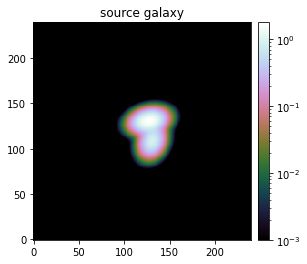

In [9]:
source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim = lenstro_util.array2image(source_sim)

# flux normalization of true source for proper comparison with pixeled reconstruction below
source_sim_comp = source_sim * subgrid_res_source**2 * (delta_pix/subgrid_res_source)**2

plt.title("source galaxy")
im = plt.imshow(source_sim_comp, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-3))
nice_colorbar(im)
plt.show()

## Define mass models: with and without substructure

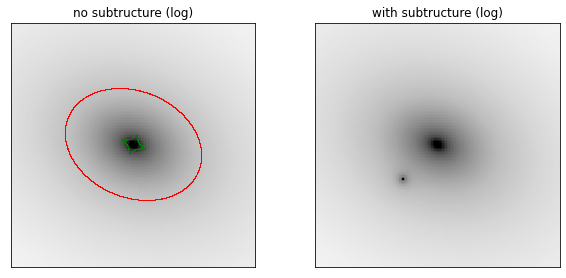

In [10]:
# basline model, with no substructure
lens_model_list = ['PEMD']
kwargs_spemd = {'theta_E': 1.6, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.1}
kwargs_lens = [kwargs_spemd]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# model with substructure, as a satellite (SIS or TNFW)
lens_model_list_ss = ['PEMD', 'TNFW']
#kwargs_sis = {'theta_E': 0.3, 'center_x': 1.6, 'center_y': 0}
kwargs_tfnw = {'alpha_Rs': 0.1, 'Rs': 0.1, 'r_trunc': 10*0.1, 'center_x': -0.9, 'center_y': -0.9}
kwargs_lens_ss = [kwargs_spemd, kwargs_tfnw]
lens_model_class_ss = LensModel(lens_model_list=lens_model_list_ss)

# display the lens models
if True:
    fig = plt.figure(figsize=(10, 4.5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title("no subtructure (log)")
    ax = lens_plot.lens_model_plot(ax, lens_model_class, kwargs_lens, numPix=num_pix*2, deltaPix=delta_pix/2., 
                                   sourcePos_x=source_center_y, sourcePos_y=source_center_y,
                                   point_source=False, with_caustics=True)
    ax = plt.subplot(1, 2, 2)
    ax.set_title("with subtructure (log)")
    ax = lens_plot.lens_model_plot(ax, lens_model_class_ss, kwargs_lens_ss, numPix=num_pix*2, deltaPix=delta_pix/2., 
                                   sourcePos_x=source_center_y, sourcePos_y=source_center_y,
                                   point_source=False, with_caustics=False)
    plt.show()

## Define a function that generates simulate the lensed image given a mass model

In [11]:
def simulate_lens_image(lensmodel_class, kwargslens, display_results=True, fig_title=None):
    if parametric_ray_tracing:
        # specify supersampling when doing parametric ray-tracing 
        kwargs_numerics = {'supersampling_factor': 3}
        imageModel = ImageModel(data_class_empty, psf_class, lensmodel_class, source_model_class, 
                                lens_light_model_class, point_source_class=None, 
                                kwargs_numerics=kwargs_numerics)
        # generate the image
        image_sim_no_noise = imageModel.image(kwargslens, kwargs_source, kwargs_lens_light, kwargs_ps=None)
    else:
        imageModel = ImageModel(data_class_empty, psf_class, lens_model_class, source_model_class, 
                                lens_light_model_class, point_source_class=None,
                                kwargs_numerics={'supersampling_factor': 1})
        # build the pixelated lensing operator
        lensing_op_sim = LensingOperator(lens_model_class, image_grid, source_grid, num_pix, subgrid_res_source,
                                         source_interpolation='bilinear')
        # ray tracing to generate the lensed source
        source_sim_1d = lenstro_util.image2array(source_sim)
        image_sim_no_noise_1d = lensing_op_sim.source2image(source_sim_1d, kwargs_lens=kwargslens)
        # PSF convolution
        image_sim_no_noise = imageModel.ImageNumerics.re_size_convolve(image_sim_no_noise_1d)
    
    # add noise : gausssian, or gaussian+poisson
    bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
    noise = bkg
    if exp_time is not None:
        poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
        noise += poisson
    image_sim = image_sim_no_noise + noise

    # update corresponding variables with simulated image and noise map
    kwargsdata = copy.deepcopy(kwargs_data_empty)
    kwargsdata['image_data'] = image_sim
    if exp_time is None:
        kwargsdata['noise_map'] = background_rms * np.ones_like(image_sim)
    dataclass = ImageData(**kwargsdata)
    
    if display_results:
        # get centroids of mass components
        mass_center_x_list, mass_center_y_list = [], []
        for kwargs in kwargslens:
            c_x_pix, c_y_pix = dataclass.map_coord2pix(kwargs['center_x'], kwargs['center_y'])
            mass_center_x_list.append(c_x_pix)
            mass_center_y_list.append(c_y_pix)
        
        fig = plt.figure(figsize=(15, 4.5))
        if fig_title is not None: fig.suptitle(fig_title, fontsize=16)
        ax = plt.subplot(1, 3, 1)
        ax.set_title("source plane, unconvolved")
        im = ax.imshow(source_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
        nice_colorbar(im)
        ax = plt.subplot(1, 3, 2)
        ax.set_title("image plane, convolved")
        im = ax.imshow(image_sim, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
        ax.plot(mass_center_x_list, mass_center_y_list, marker='o', color='red', alpha=1, linestyle='none')
        nice_colorbar(im)
        ax = plt.subplot(1, 3, 3)
        ax.set_title("noise map")
        im = ax.imshow(np.sqrt(dataclass.C_D), origin='lower', cmap='viridis')
        nice_colorbar(im)
        plt.show()
        
    return dataclass

## Generate simulated images

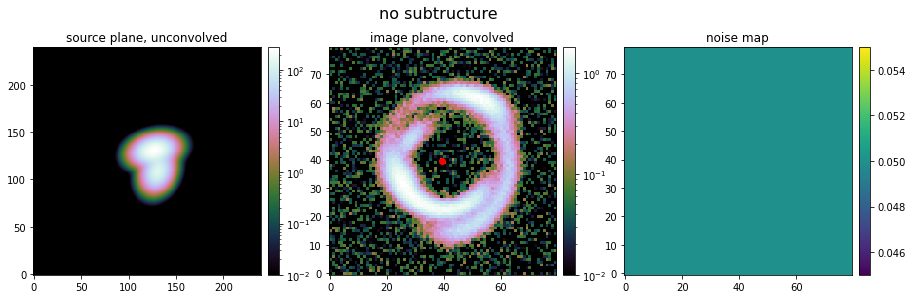

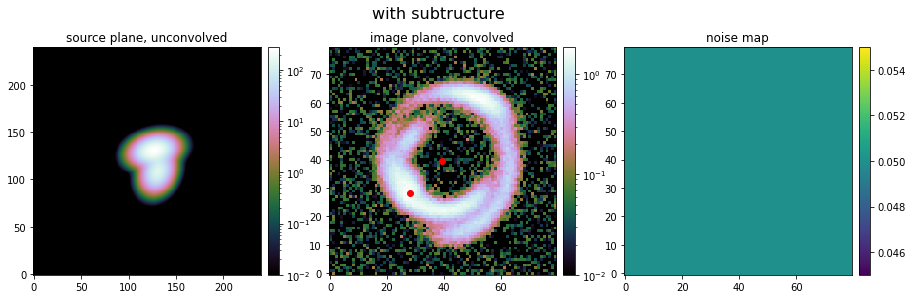

In [12]:
data_class = simulate_lens_image(lens_model_class, kwargs_lens, display_results=True, fig_title="no subtructure")
data_class_ss = simulate_lens_image(lens_model_class_ss, kwargs_lens_ss, display_results=True, fig_title="with subtructure")


## Define a mask
Mainly to speedup computation here

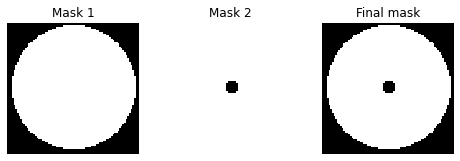

In [13]:
mask_kwargs = {
    'mask_type': 'circle',
    'radius_list': [3] + [0.3], 
    'center_list': [None] + [None],
    'inverted_list': [False] + [True], 
    'operation_list': ['inter'],
}
imgMask = ImageMask(mask_shape=data_class.data.shape,
                    delta_pix=data_class.pixel_width, 
                    **mask_kwargs)
likelihood_mask = imgMask.get_mask(show_details=True)

## Define a function that takes a mass model and solve for the source

In [14]:
def solve_for_source(dataclass, lensmodel, kwargslens, num_iter=20, min_threshold=3, threshold_increment_high_freq=1, 
                     verbose=True, display_results=True):
    source_model_list_sparsefit = ['SLIT_STARLETS']
    kwargs_starlets_source = {'n_scales': 6, 'n_pixels': np.size(dataclass.data)*subgrid_res_source**2}
    kwargssource_sparsefit = [kwargs_starlets_source]
    sourcemodel_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

    kwargs_sparse_solver = {
        'supersampling_factor_source': subgrid_res_source,
        'minimal_source_plane': True,
        'min_threshold': min_threshold,  # 3 sigmas
        'threshold_increment_high_freq': threshold_increment_high_freq,  # 3+2 sigma
        'num_iter_source': num_iter,
        'num_iter_weights': 2,
        'verbose': verbose,
        'show_steps': False,
        'thread_count': 8,  # number of processors
    }

    imageSparseFit = ImageLinearFit(dataclass, psf_class=psf_class, 
                                    lens_model_class=lensmodel,
                                    source_model_class=sourcemodel_sparsefit,
                                    likelihood_mask=likelihood_mask,
                                    kwargs_pixelbased=kwargs_sparse_solver)
    #start_time = time.time()
    solve_results = imageSparseFit.image_pixelbased_solve(kwargs_lens=kwargslens, kwargs_source=kwargssource_sparsefit,
                                                      kwargs_lens_light=None, kwargs_ps=None, kwargs_special=None)
    #end_time = time.time()
    #print("Runtime : {:.3f} s".format(end_time-start_time))
    
    if display_results:
        imageSparseFit.PixelSolver.plot_results(vmin_res=-3, vmax_res=3, log_scale=True, with_history=False,
                                                vmin_source=1e-2, vmin_image=1e-2,
                                                cmap_source=cmap_flux, 
                                                cmap_image=cmap_flux)
    
    # project the estimated source onto source plane for comparison with groundtruth
    source_sparsefit = sourcemodel_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargssource_sparsefit)
    source_sparsefit = lenstro_util.array2image(source_sparsefit)
    
    return sourcemodel_sparsefit, kwargssource_sparsefit, source_sparsefit, imageSparseFit.PixelSolver


## Reconstruct the source with true lens models
### Without subtructure

SizeablePlaneGrid: source grid has been reduced from 240 to 114 side pixels
=== iteration 0-0 === : loss+reg = 267.0951|nan, red-chi2 = 48.1167|nan, step_diff = 10.5261|nan
=== iteration 1-0 === : loss+reg = 48.0414|nan, red-chi2 = 7.3581|nan, step_diff = 7.4546|nan
Negative image pixels ? False (min = 0.00e+00)
Negative source pixels ? False (min = 0.00e+00)


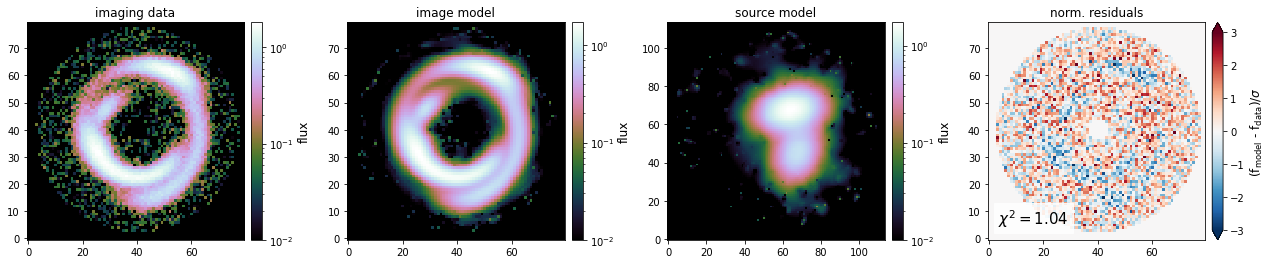

In [15]:
solve_results = solve_for_source(data_class, lens_model_class, kwargs_lens)
source_estim = solve_results[2]

### With subtructure

SizeablePlaneGrid: source grid has been reduced from 240 to 112 side pixels
=== iteration 0-0 === : loss+reg = 256.2101|nan, red-chi2 = 46.0512|nan, step_diff = 11.0100|nan
=== iteration 1-0 === : loss+reg = 48.1819|nan, red-chi2 = 7.4161|nan, step_diff = 7.4282|nan
Negative image pixels ? True (min = -1.48e-03)
Negative source pixels ? False (min = 0.00e+00)


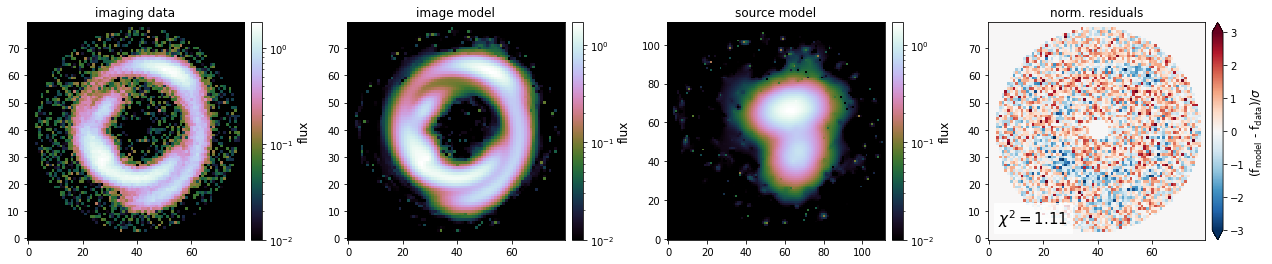

In [16]:
solve_results_ss = solve_for_source(data_class_ss, lens_model_class_ss, kwargs_lens_ss)
source_estim_ss = solve_results_ss[2]

## Reconstruct the source with lens model missing substructure

#### With fiducial regularisation

SizeablePlaneGrid: source grid has been reduced from 240 to 114 side pixels
=== iteration 0-0 === : loss+reg = 253.0362|nan, red-chi2 = 45.5706|nan, step_diff = 10.4329|nan
=== iteration 1-0 === : loss+reg = 53.7675|nan, red-chi2 = 8.4697|nan, step_diff = 7.4343|nan
Negative image pixels ? False (min = 0.00e+00)
Negative source pixels ? False (min = 0.00e+00)


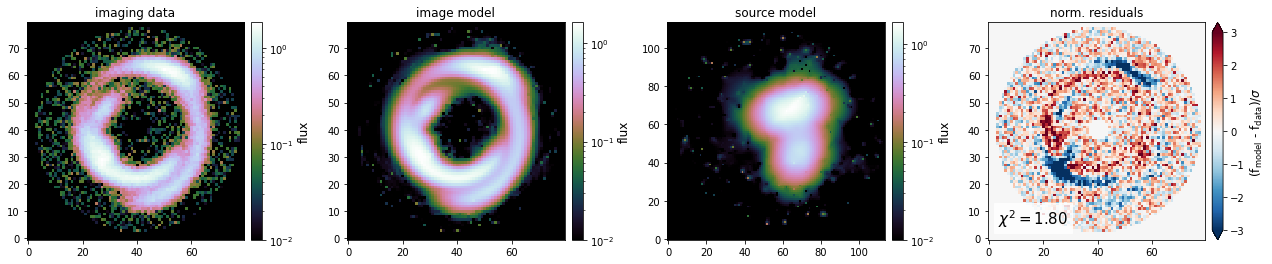

In [17]:
solve_results_ss_smooth = solve_for_source(data_class_ss, lens_model_class, kwargs_lens)
source_estim_ss_smooth = solve_results_ss_smooth[2]

# extract some images for potential correction
solver_ss = solve_results_ss_smooth[3]
model_ss_smooth = solver_ss.image_model(unconvolved=False)
residuals_model = data_class_ss.data - model_ss_smooth

#### Over-regularised solution

SizeablePlaneGrid: source grid has been reduced from 240 to 114 side pixels
=== iteration 0-0 === : loss+reg = 294.2044|nan, red-chi2 = 45.6241|nan, step_diff = 10.4195|nan
=== iteration 1-0 === : loss+reg = 227.2495|nan, red-chi2 = 24.4490|nan, step_diff = 2.0264|nan
Negative image pixels ? False (min = 0.00e+00)
Negative source pixels ? False (min = 0.00e+00)


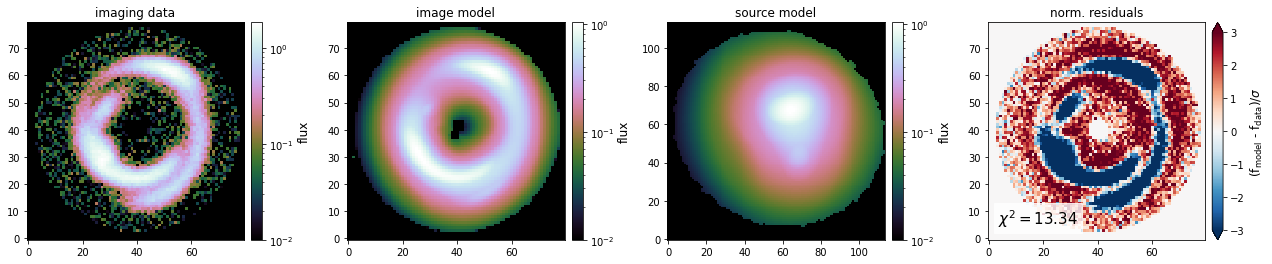

In [18]:
solve_results_ss_smooth_overreg = solve_for_source(data_class_ss, lens_model_class, kwargs_lens,
                                                   min_threshold=100)
source_estim_ss_smooth_overreg = solve_results_ss_smooth_overreg[2]

# extract some images for potential correction
solver_ss_overreg = solve_results_ss_smooth_overreg[3]
model_ss_smooth_overreg = solver_ss_overreg.image_model(unconvolved=False)
residuals_model_overreg = data_class_ss.data - model_ss_smooth_overreg

min/max for source model 'no substructure': -4.773028192920099e-09/1.733796715736389
SDR for model 'no substructure' = 11.550
min/max for source model 'with substructure': -5.995389074087088e-09/1.7159841060638426
SDR for model 'with substructure' = 11.410
min/max for source model 'wrong lens model': -5.355104804038963e-09/1.6635730266571034
SDR for model 'wrong lens model' = 8.991
min/max for source model 'wrong lens model, over-reg.': -1.5425030142068702e-09/1.0375555753707884
SDR for model 'wrong lens model, over-reg.' = 3.220


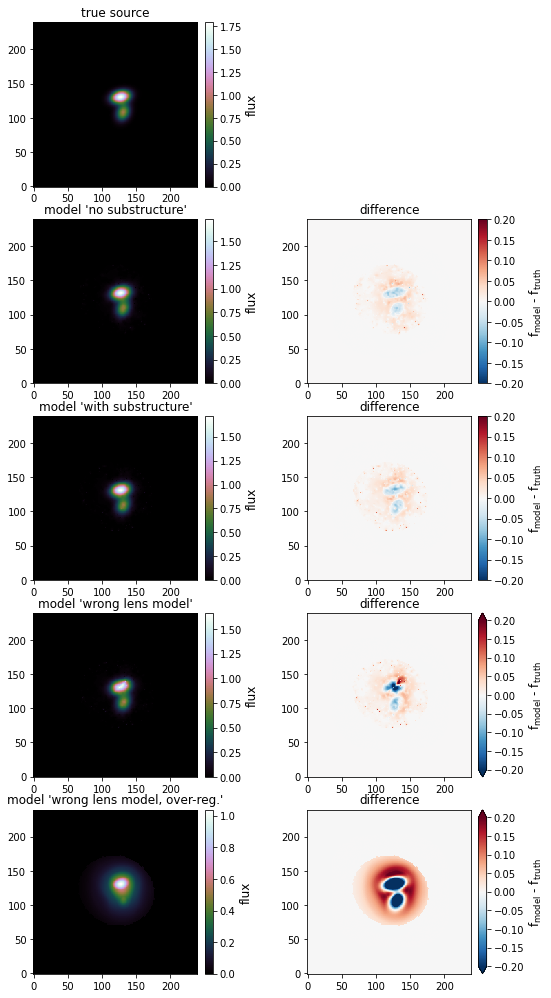

In [19]:
fig = SolverPlotter.plot_source_residuals_comparison(source_sim_comp, 
                                                     [source_estim, source_estim_ss, source_estim_ss_smooth, source_estim_ss_smooth_overreg], 
                                                     ['no substructure', 'with substructure', 'wrong lens model', 'wrong lens model, over-reg.'],
                                                     vmin_res=-0.2, vmax_res=0.2)
plt.show()

## Pixelated potential corrections required to improve the fit

The cells below follow Koopmans 2005 (K05, https://ui.adsabs.harvard.edu/abs/2005MNRAS.363.1136K/abstract), to construct the different operators needed for reconstructing potential perturbations on a regular pixelated grid.

The difference here is that we regularize the potential perturbations with starlets, in addition to a similar regularization for the source.

### Define the pixelated potential grid

In [20]:
# TODO: for now, the pixelated grid for pertubartions is at the data resolution (pot_factor > 1 NOT SUPPORTED)
subgrid_factor_pot = 1  # downsampling factor wrt imaging data resolution
num_pix_pot, delta_pix_pot = int(num_pix/subgrid_factor_pot), float(delta_pix*subgrid_factor_pot)

# data specification (coordinates, etc.)
_, _, ra_at_xy_0_pot, dec_at_xy_0_pot, _, _, Mpix2coord_pot, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix_pot, deltapix=delta_pix_pot, inverse=False)

potential_grid = RegularGrid(num_pix_pot, num_pix_pot, Mpix2coord_pot, ra_at_xy_0_pot, dec_at_xy_0_pot)
ra_grid_pot, dec_grid_pot = potential_grid.coordinates_evaluate
x_axis_pot, y_axis_pot = lenstro_util.get_axes(ra_grid_pot, dec_grid_pot)

def pixelated_potential(lensmodel_class, kwargslens):
    pot_1d = lensmodel_class.potential(ra_grid_pot, dec_grid_pot, kwargslens)
    return a2i(pot_1d)

def pixelated_deflection(lensmodel_class, kwargslens):
    alpha_x_1d, alpha_y_1d = lensmodel_class.alpha(ra_grid_pot, dec_grid_pot, kwargslens)
    return a2i(np.sqrt(alpha_x_1d**2 + alpha_y_1d**2))

def pixelated_convergence(lensmodel_class, kwargslens):
    kappa_1d = lensmodel_class.kappa(ra_grid_pot, dec_grid_pot, kwargslens)
    return a2i(kappa_1d)

### Visualize the true correction on the grid

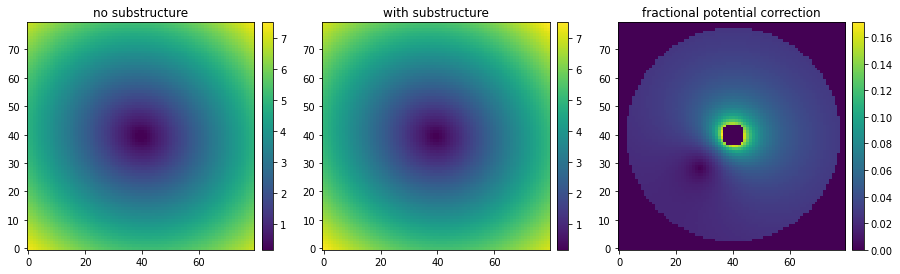

In [21]:
pot = pixelated_potential(lens_model_class, kwargs_lens)
pot_ss = pixelated_potential(lens_model_class_ss, kwargs_lens_ss)
vmin_pot, vmax_pot = pot_ss.min(), pot_ss.max()

# get the 'true' delta_psi
pot_corr_truth = pot_ss - pot

fig = plt.figure(figsize=(15, 4.5))
ax = plt.subplot(1, 3, 1)
ax.set_title("no substructure")
im = ax.imshow(pot, origin='lower', cmap='viridis', vmin=vmin_pot, vmax=vmax_pot)
nice_colorbar(im)
ax = plt.subplot(1, 3, 2)
ax.set_title("with substructure")
im = ax.imshow(pot_ss, origin='lower', cmap='viridis', vmin=vmin_pot, vmax=vmax_pot)
nice_colorbar(im)
ax = plt.subplot(1, 3, 3)
ax.set_title("fractional potential correction")
frac_pot_corr = (pot_corr_truth / pot) * likelihood_mask
im = ax.imshow(frac_pot_corr, origin='lower', cmap='viridis') #, vmin=vmin_pot, vmax=vmax_pot)
nice_colorbar(im)
plt.show()

### Define functions to compute the derivative operator

In [22]:
def prepare_source_interpol(s):
    scale_source = delta_pix/subgrid_res_source  # pixel size on source plane
    
    # we define an interpol profile for source light `s`
    sourcemodel_interp = LightModel(['INTERPOL'])
    kwargssource_interp = [{
        'image': s, 'scale': scale_source, 
        'amp': 1, 'center_x': 0, 'center_y': 0, 'phi_G': 0,
    }]
    return sourcemodel_interp, kwargssource_interp, #s_evaluated

def diff_source_interpol(s):
    diff = delta_pix/subgrid_res_source  # pixel size on source plane
    
    sourcemodel_interp, kwargssource_interp = prepare_source_interpol(s)
    
    # 1a) derivative of the source in each direction
    sourcemodel_interp.delete_interpol_caches()
    ds_x_p = sourcemodel_interp.surface_brightness(ra_grid_hd + diff, dec_grid_hd, kwargssource_interp)
    sourcemodel_interp.delete_interpol_caches()
    ds_x_m = sourcemodel_interp.surface_brightness(ra_grid_hd - diff, dec_grid_hd, kwargssource_interp)
    ds_x = (ds_x_p - ds_x_m) / (2.*diff)
    
    sourcemodel_interp.delete_interpol_caches()
    ds_y_p = sourcemodel_interp.surface_brightness(ra_grid_hd, dec_grid_hd + diff, kwargssource_interp)
    sourcemodel_interp.delete_interpol_caches()
    ds_y_m = sourcemodel_interp.surface_brightness(ra_grid_hd, dec_grid_hd - diff, kwargssource_interp)
    ds_y = (ds_y_p - ds_y_m) / (2.*diff)
    
    scale = kwargssource_interp[0]['scale']
    kwargssource_interp_dx = [{
        'image': a2i(ds_x), 'scale': scale, 
        'amp': 1, 'center_x': 0, 'center_y': 0, 'phi_G': 0,
    }]
    kwargssource_interp_dy = [{
        'image': a2i(ds_y), 'scale': scale, 
        'amp': 1, 'center_x': 0, 'center_y': 0, 'phi_G': 0,
    }]
    # 1b) evaluate those derivatives at the pixels in source plane ray-traced (with smooth potential) from the pixelated potential grid
    ra_grid_pot_src, dec_grid_pot_src = lens_model_class.ray_shooting(ra_grid_pot, dec_grid_pot, kwargs_lens)
    sourcemodel_interp.delete_interpol_caches()
    ds_x_potgrid = sourcemodel_interp.surface_brightness(ra_grid_pot_src, dec_grid_pot_src, kwargssource_interp_dx)
    sourcemodel_interp.delete_interpol_caches()
    ds_y_potgrid = sourcemodel_interp.surface_brightness(ra_grid_pot_src, dec_grid_pot_src, kwargssource_interp_dy)
    
    return ds_x_potgrid, ds_y_potgrid

def diff_source_findiff(s, lensmodel, kwargslens):
    diff = delta_pix/subgrid_res_source  # pixel size on source plane
    
    sourcemodel_interp, kwargssource_interp = prepare_source_interpol(s)
    
    # 1a) derivative of the source in each direction
    d_dx_class = findiff.FinDiff(1, diff, 1, acc=4)
    d_dy_class = findiff.FinDiff(0, diff, 1, acc=4)
    ds_x = d_dx_class(s)
    ds_y = d_dy_class(s)
    
    scale = kwargssource_interp[0]['scale']
    kwargssource_interp_dx = [{
        'image': ds_x, 'scale': scale, 
        'amp': 1, 'center_x': 0, 'center_y': 0, 'phi_G': 0,
    }]
    kwargssource_interp_dy = [{
        'image': ds_y, 'scale': scale, 
        'amp': 1, 'center_x': 0, 'center_y': 0, 'phi_G': 0,
    }]
    
    # 1b) evaluate those derivatives at the pixels in source plane ray-traced (with smooth potential) from the pixelated potential grid
    ra_grid_pot_src, dec_grid_pot_src = lensmodel.ray_shooting(ra_grid_pot, dec_grid_pot, kwargslens)
    sourcemodel_interp.delete_interpol_caches()
    ds_x_potgrid = sourcemodel_interp.surface_brightness(ra_grid_pot_src, dec_grid_pot_src, kwargssource_interp_dx)
    sourcemodel_interp.delete_interpol_caches()
    ds_y_potgrid = sourcemodel_interp.surface_brightness(ra_grid_pot_src, dec_grid_pot_src, kwargssource_interp_dy)
    
    return a2i(ds_x_potgrid), a2i(ds_y_potgrid)

def operator_eq6_matrix(s, lensmodel, kwargslens, separately=False, diff=None):
    """
    s: 2D array of source surface brightness
    
    This is returned as a single matrix - (D_s_x * D_x + D_s_y * D_y)( . )
    which is equivalent (up to numerical errors ~1e-13) to apply - D_s_x * D_x( . ) and - D_s_y * D_y( . ) separately, before the summation.
    """
    if diff is None:
        diff = delta_pix_pot
    shape = (num_pix_pot, num_pix_pot)
    
    # derivatives of source intensities
    #d_s_x, d_s_y = diff_source_interpol(s)
    d_s_x, d_s_y = diff_source_findiff(s, lensmodel, kwargslens)
    
    # put them into sparse diagonal matrices
    D_s_x = sparse.diags([i2a(d_s_x)], [0])
    D_s_y = sparse.diags([i2a(d_s_y)], [0])
    
    # now we compute the derivative operator as two matrices D_x, D_y
    d_dx_class = findiff.FinDiff(1, diff, 1, acc=4)
    d_dy_class = findiff.FinDiff(0, diff, 1, acc=4)
    D_x = d_dx_class.matrix(shape)  # sparse matrix
    D_y = d_dy_class.matrix(shape)  # sparse matrix
    
    if separately:
        return D_s_x.dot(D_x), D_s_y.dot(D_y)
    else:
        return D_s_x.dot(D_x) + D_s_y.dot(D_y)

def diff_potential(psi, diff=None):
    if diff is None:
        diff = delta_pix_pot
    
    d_dx_class = findiff.FinDiff(1, diff, 1, acc=4)
    d_dy_class = findiff.FinDiff(0, diff, 1, acc=4)
    dpsi_x = d_dx_class(psi)
    dpsi_y = d_dy_class(psi)
    return dpsi_x, dpsi_y

#### Derivatives of potential corrections

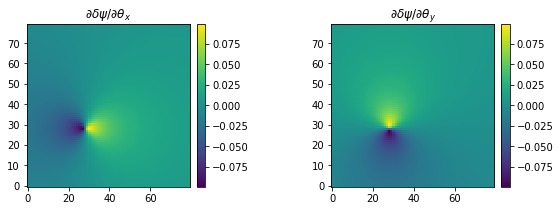

In [23]:
d_pot_x, d_pot_y = diff_potential(pot_corr_truth)

plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
ax.set_title(r"$\partial \delta\psi / \partial \theta_x$")
im = ax.imshow(d_pot_x, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 2, 2)
ax.set_title(r"$\partial \delta\psi / \partial \theta_y$")
im = ax.imshow(d_pot_y, origin='lower')
nice_colorbar(im)
plt.show()

#### Derivatives of source light

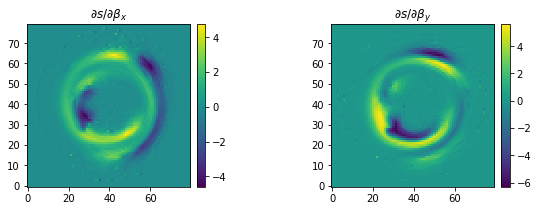

In [24]:
d_s_x, d_s_y = diff_source_findiff(source_estim_ss, lens_model_class_ss, kwargs_lens_ss)

plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
ax.set_title(r"$\partial s / \partial \beta_x$")
im = ax.imshow(d_s_x, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 2, 2)
ax.set_title(r"$\partial s / \partial \beta_y$")
im = ax.imshow(d_s_y, origin='lower')
nice_colorbar(im)
plt.show()

#### Minus the scalar product of both derivatives: equation (6) of Koopmans 2005

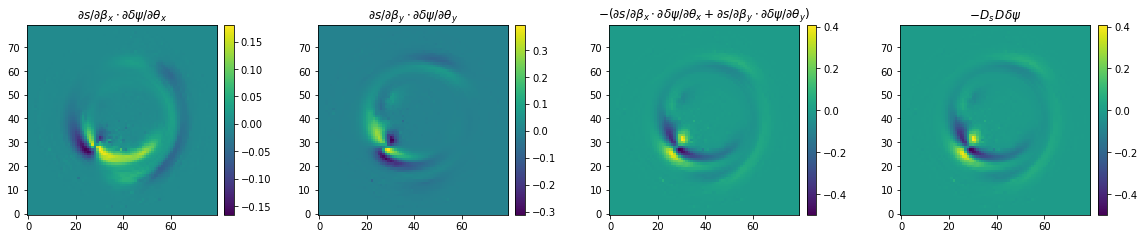

In [25]:
# components x and y separately
DDx, DDy = operator_eq6_matrix(source_estim_ss, lens_model_class_ss, kwargs_lens_ss, separately=True)
DDx_psi = a2i(DDx.dot(i2a(pot_corr_truth)))
DDy_psi = a2i(DDy.dot(i2a(pot_corr_truth)))

# as single operator
DD_op_matrix = operator_eq6_matrix(source_estim_ss, lens_model_class_ss, kwargs_lens_ss)
DD_psi = a2i(DD_op_matrix.dot(i2a(pot_corr_truth)))


plt.figure(figsize=(20, 3.5))
ax = plt.subplot(1, 4, 1)
ax.set_title(r"$\partial s / \partial \beta_x \cdot \partial \delta\psi / \partial \theta_x$")
im = ax.imshow(DDx_psi, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 4, 2)
ax.set_title(r"$\partial s / \partial \beta_y \cdot \partial \delta\psi / \partial \theta_y$")
im = ax.imshow(DDy_psi, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 4, 3)
ax.set_title(r"$- (\partial s / \partial \beta_x \cdot \partial \delta\psi / \partial \theta_x + \partial s / \partial \beta_y \cdot \partial \delta\psi / \partial \theta_y)$")
im = ax.imshow(- DDx_psi - DDy_psi, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 4, 4)
ax.set_title(r"$- D_s\,D \delta\psi$")
im = ax.imshow(- DD_psi, origin='lower')
nice_colorbar(im)
plt.show()

#### Visualize the residual map $\delta d$ for some potential correction and assuming true source is known

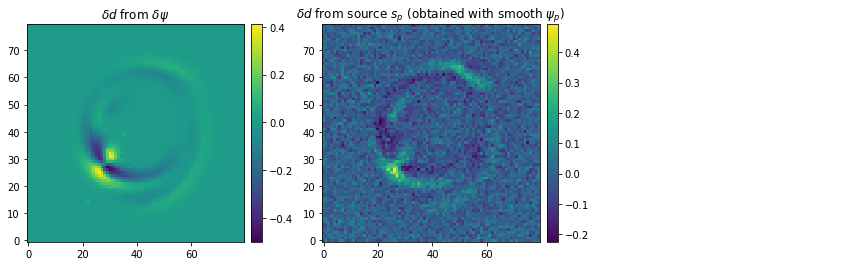

In [26]:
DD_op_matrix = operator_eq6_matrix(source_estim_ss, lens_model_class_ss, kwargs_lens_ss)

# residuals_potential is delta d, that should match the residuals_model for correct potential correction
residuals_potential = - a2i(DD_op_matrix.dot(i2a(pot_corr_truth)))

plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
ax.set_title(r"$\delta d$ from $\delta \psi$")
im = ax.imshow(residuals_potential, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 3, 2)
ax.set_title(r"$\delta d$ from source $s_p$ (obtained with smooth $\psi_p$)")
im = ax.imshow(residuals_model, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 3, 3)
ax.axis('off')
#ax.set_title("difference, normalized to the noise")
#im = ax.imshow((residuals_model - residuals_potential) / background_rms, origin='lower', cmap='RdBu_r', vmin=-6, vmax=6)
#nice_colorbar(im)
plt.show()

#### Visualize the potential correction $\delta \psi$ when true source light is known, with _no regularization_

(6400, 6400)
(6400, 6400)


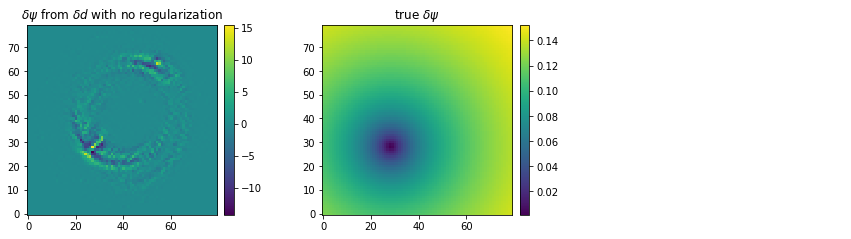

In [27]:
# matrix of the linear system
DD_op_matrix = operator_eq6_matrix(source_estim_ss_smooth, lens_model_class_ss, kwargs_lens_ss)
print(DD_op_matrix.toarray().shape)

# ~inverse matrix
#DD_op_matrix_inv = sparse.linalg.inv(DD_op_matrix.tocsc())
DD_op_matrix_inv = DD_op_matrix.T
print(DD_op_matrix_inv.toarray().shape)

# "solve" the unregularized inverse problem:
#residuals_noise = np.ones_like(residuals_model)*np.median(residuals_model) * np.random.randn(*residuals_model.shape)
pot_corr_result = - a2i(DD_op_matrix_inv.dot(i2a(residuals_model)))

plt.figure(figsize=(15, 3.5))
ax = plt.subplot(1, 3, 1)
ax.set_title(r"$\delta \psi$ from $\delta d$ with no regularization")
im = ax.imshow(pot_corr_result, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 3, 2)
ax.set_title(r"true $\delta \psi$")
im = ax.imshow(pot_corr_truth, origin='lower')
nice_colorbar(im)
ax = plt.subplot(1, 3, 3)
ax.axis('off')
#ax.set_title("difference")
#im = ax.imshow(pot_corr_truth - pot_corr_result, origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
#nice_colorbar(im)
plt.show()

### Visualise the operator for inverse problem solving

We now make a pause before going on with the optimization.

We would like to characterise the following problem for the **pixelated potential corrections** $\delta\psi$:
$$
D\, \delta\psi = \delta\mathsf{d}
$$
where the operator is given by
$$
D = - D_{\rm \mathsf{s}}(\mathsf{s_{p}}) \, D_{\rm \psi} \\
D_{\rm \mathsf{s}}(\mathsf{s_{p}}) \ :\ {\rm from\ derivatives\ of\ the\ source\ with\ no\ potential\ correction} \\
D_{\rm \psi} \ :\ {\rm from\ derivatives\ of\ the\ current\ (total)\ potential\ map}
$$
and the residual map is
$$
\delta\mathsf{d} = \mathsf{Y} - \mathsf{F}\,\mathsf{s_p} \ ({\rm the\ residual\ map}) \\
$$

The source is found

$$
\mathsf{F}\,\mathsf{s_{p}} = \mathsf{Y'}
$$

#### Apply the $D$ operator to test images

linear operator shape: (6400, 6400)


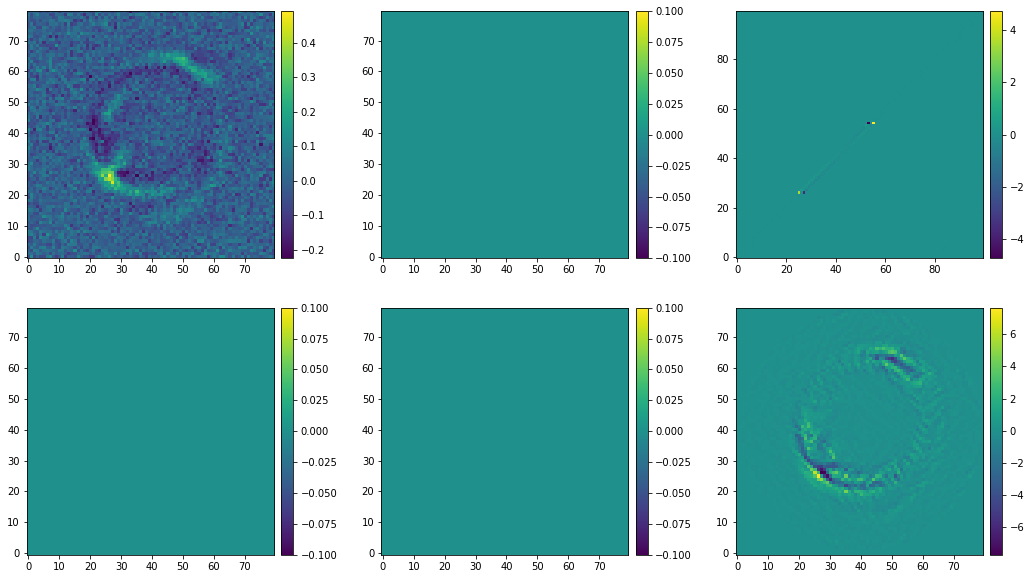

In [28]:
ones = np.ones_like(data_class_ss.data)
zeros = np.zeros_like(data_class_ss.data)
dirac = np.zeros_like(data_class_ss.data)
dirac[len(dirac)//2, len(dirac)//2] = 1.
noise = background_rms * np.random.randn(*data_class_ss.data.shape)

D = operator_eq6_matrix(source_estim_ss_smooth_overreg, lens_model_class, kwargs_lens)
D_final = operator_eq6_matrix(source_estim_ss, lens_model_class, kwargs_lens)


delta_d_visu = data_class_ss.data - model_ss_smooth  # the vector we want to match
delta_psi_visu = zeros  # the vector we want to solve for
D_visu = - D  # the linear operator

print("linear operator shape:", D_visu.shape)

#delta_psi_inversion = a2i(np.linalg.solve(D_visu.todense(), i2a(delta_psi_visu)))
delta_psi_inversion = a2i(D_visu.T.dot(i2a(delta_psi_visu)))
grad_mse = a2i(D_visu.T.dot(i2a(delta_d_visu) - D_visu.dot(i2a(delta_psi_visu))))


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
ax = axes[0, 0]
im = ax.imshow( delta_d_visu )
nice_colorbar(im)
ax = axes[0, 1]
im = ax.imshow( delta_psi_visu )
nice_colorbar(im)
ax = axes[0, 2]
im = ax.imshow( D_visu.todense()[400:500, 400:500] )
#im = ax.imshow( a2i(D_visu.dot(i2a(delta_psi_visu))) )
nice_colorbar(im)
ax = axes[1, 0]
im = ax.imshow( a2i(D_visu.dot(i2a(delta_psi_visu))) )
nice_colorbar(im)
ax = axes[1, 1]
im = ax.imshow( delta_psi_inversion )
nice_colorbar(im)
ax = axes[1, 2]
im = ax.imshow( grad_mse )
nice_colorbar(im)

plt.show()

#### Decompose true poential corrections in starlet space

This will allow us to compute "true" threshold levels in each starlet scales.

__WARNING__: the thresholds below are computed for 1/potential for beter dynamic range !

0.0012978054388881333 0.1526791810467767
6


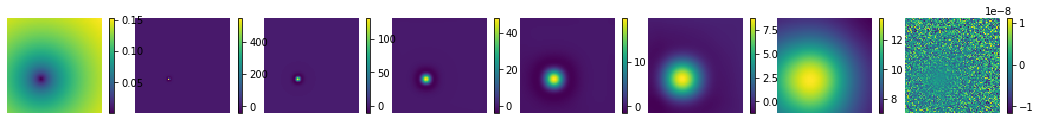

[521.590298461914, 124.57878112792969, 45.71030616760254, 18.985652732849122, 8.318301963806151, 12.824668407440186]


In [29]:
#negative_pot_corr_truth = - pot_corr_truth

print(pot_corr_truth.min(), pot_corr_truth.max())

starlets_pot = SLIT_Starlets(second_gen=False, thread_count=8)
n_scales_pot = int(np.log2(num_pix_pot))  # maximum nb of scales
print(n_scales_pot)

#pot_corr_truth_coeffs = starlets_pot.decomposition_2d(pot_corr_truth, n_scales_pot)
#pot_corr_truth_back = starlets_pot.function_2d(pot_corr_truth_coeffs, n_scales_pot, num_pix_pot**2)
pot_corr_truth_coeffs = starlets_pot.decomposition_2d(1. / pot_corr_truth, n_scales_pot)
pot_corr_truth_back = 1. / starlets_pot.function_2d(pot_corr_truth_coeffs, n_scales_pot, num_pix_pot**2)

fig, axes = plt.subplots(1, n_scales_pot+2, figsize=(18, 3))
ax = axes[0]
ax.axis('off')
im = ax.imshow(pot_corr_truth) #, norm=LogNorm())
nice_colorbar(im)
thresholds_true = []
for i in range(n_scales_pot):
    ax = axes[i+1]
    ax.axis('off')
    im = ax.imshow(pot_corr_truth_coeffs[i]) #, norm=LogNorm())
    nice_colorbar(im)
    
    # get the threshold as 0.95% of the value (i.e. consider remaining 5% to be below 'noise')
    threshold_i = 0.95 * pot_corr_truth_coeffs[i].max()
    thresholds_true.append(threshold_i)
    
ax = axes[-1]
ax.axis('off')
im = ax.imshow(pot_corr_truth - pot_corr_truth_back) #, norm=LogNorm())
nice_colorbar(im)

plt.show()

print(thresholds_true)

### Solving for the source and potential perturbations

#### Some useful functions

In [30]:
def mad(x):
    return np.median(np.abs(x - np.median(x)))

def correct_potential(pot_corr, lensmodel, kwargslens):
    # add the correction to current potential
    pot = lensmodel.potential(ra_grid_pot, dec_grid_pot, kwargslens)
    f_ = a2i(pot) + pot_corr
    
    # compute numerically deflection angles
    lensmodel_tmp = LensModel(['INTERPOL'])
    kwargslens_tmp = [{
        'grid_interp_x': x_axis_pot, 'grid_interp_y': y_axis_pot, 
        'f_': f_,
    }]
    diff = 1e-5   #delta_pix_pot
    f_x_num, f_y_num = lensmodel_tmp.alpha(ra_grid_pot, dec_grid_pot, kwargslens_tmp, diff=diff)
    f_x_num, f_y_num = a2i(f_x_num), a2i(f_y_num)
    
    # setup the final classes and parameters
    lensmodel_updated = LensModel(['INTERPOL'])
    kwargslens_updated = [{
        'grid_interp_x': x_axis_pot, 'grid_interp_y': y_axis_pot, 
        'f_': f_, 'f_x': f_x_num, 'f_y': f_y_num,
    }]
    return lensmodel_updated, kwargslens_updated

def lens_model_param2interpol(lensmodel, kwargslens):
    if lensmodel.lens_model_list == ['INTERPOL']:
        return lensmodel, kwargslens
    f_ = lensmodel.potential(ra_grid_pot, dec_grid_pot, kwargslens)
    f_x, f_y = lensmodel.alpha(ra_grid_pot, dec_grid_pot, kwargslens)
    #f_xx, f_xy, _, f_yy = lensmodel.hessian(ra_grid_pot, dec_grid_pot, kwargslens)
    lensmodel_interp = LensModel(['INTERPOL'])
    kwargslens_interp = [{
        'grid_interp_x': x_axis_pot, 'grid_interp_y': y_axis_pot, 
        'f_': a2i(f_), 'f_x': a2i(f_x), 'f_y': a2i(f_y),
        #'f_xx': a2i(f_xx), 'f_yy': a2i(f_yy), 'f_xy': a2i(f_xy),
    }]
    return lensmodel_interp, kwargslens_interp

def extract_lens_model_properties(lensmodel_smooth, kwargslens_smooth, lensmodel_interpol, kwargslens_interpol):
    diff = 1e-5   #delta_pix_pot
    psi_smooth   = lensmodel_smooth.potential(ra_grid_pot, dec_grid_pot, kwargslens_smooth)
    psi_final    = lensmodel_interpol.potential(ra_grid_pot, dec_grid_pot, kwargslens_interpol)
    alpha_smooth_xy = lensmodel_smooth.alpha(ra_grid_pot, dec_grid_pot, kwargslens_smooth)
    alpha_smooth = np.sqrt(alpha_smooth_xy[0]**2 + alpha_smooth_xy[1]**2)  # norm of deflection angle vector field
    alpha_final_xy  = lensmodel_interpol.alpha(ra_grid_pot, dec_grid_pot, kwargslens_interpol, diff=diff)
    alpha_final = np.sqrt(alpha_final_xy[0]**2 + alpha_final_xy[1]**2)     # norm of deflection angle vector field
    kappa_smooth = lensmodel_smooth.kappa(ra_grid_pot, dec_grid_pot, kwargslens_smooth)
    kappa_final  = lensmodel_interpol.kappa(ra_grid_pot, dec_grid_pot, kwargslens_interpol, diff=diff)
    return dict(psi_p=a2i(psi_smooth), psi=a2i(psi_final),
                alpha_p=a2i(alpha_smooth), alpha=a2i(alpha_final),
                kappa_p=a2i(kappa_smooth), kappa=a2i(kappa_final))

#### Final function that solve for the source and potential perturbations  (alternating optimization of $s$ and $\delta\psi$)

In [31]:
def solve_for_potential_correction(dataclass, init_lensmodel, init_kwargslens, init_sourcelight, 
                                   thresholds, step_size=1e-3, min_threshold_source=3, 
                                   auto_noise_levels=False, num_iter=50, 
                                   filter_on_inverse=False, force_positivity=False):
    """
    solve iteratively with gradient descent + regularization the potential correction
    `auto_noise_levels`: if True, attempts to estimate thresholds (does not work very well)
    `thresholds`: lits of threshold values (first value for first scale, second value for following scales)
    If `auto_noise_levels` is True, it is in unit of noise levels, otherwise in units of potential corrections.
    `num_iter`: number of iterations
    
    Aliases to operators are defined below for practicality.
    No decrease of thresholds is performed along the iterations!
    """
    y = dataclass.data
    n_pixels = y.size
    
    starlets = SLIT_Starlets(second_gen=False, thread_count=8)
    n_scales = int(np.log2(num_pix_pot))  # maximum nb of scales for pixelated potential grid
    
    delta_psi_shape = (num_pix_pot, num_pix_pot)
    
    def DD(x, s, lensmodel, kwargslens):
        DD_mat = operator_eq6_matrix(s, lensmodel, kwargslens)
        return - a2i(DD_mat.dot(i2a(x)))
    def DD_T(x, s, lensmodel, kwargslens):
        DD_mat = operator_eq6_matrix(s, lensmodel, kwargslens)
        DD_mat_T = DD_mat.T
        return - a2i(DD_mat_T.dot(i2a(x)))
    def Phi(x):
        return starlets.function_2d(x, n_scales=n_scales, n_pixels=n_pixels)
    def Phi_T(x):
        return starlets.decomposition_2d(x, n_scales=n_scales)
    def H(x):
        if perfect_seeing: return x
        return signal.fftconvolve(x, psf_kernel, mode='same')
    def H_T(x):
        if perfect_seeing: return x
        return signal.fftconvolve(x, psf_kernel.T, mode='same')
    def error(lensmodel, kwargslens):
        # solve for the source at fixed lens model (INNER LOOP)
        source_results = solve_for_source(dataclass, lensmodel, kwargslens, min_threshold=min_threshold_source,
                                          verbose=False, display_results=False)
        s = source_results[2]
        solver = source_results[3]
        model = solver.image_model(unconvolved=False)
        err = (y - model)
        return err, s
    def grad_loss(lensmodel, kwargslens):
        delta_d, s_p = error(lensmodel, kwargslens)
        return - DD_T(H_T(delta_d), s_p, lensmodel, kwargslens)
    def loss(err):
        return np.linalg.norm((err*likelihood_mask).flatten(), ord=2)**2/2.
    def prox(x, level_pixels, step=None):
        if len(thresholds) == 1:
            level_const = [thresholds[0]]*n_scales
        elif len(thresholds) == 2:
            level_const = [thresholds[0]] + [thresholds[1]]*(n_scales-1)
        elif len(thresholds) == n_scales:
            level_const = thresholds
        if step is None:
            step = 1
        if filter_on_inverse:
            coeffs = Phi_T(1./x)
        else:
            coeffs = Phi_T(x)
        prox_coeffs = proximals.prox_sparsity_wavelets(coeffs, step=step, level_const=level_const, 
                                                       level_pixels=level_pixels, l_norm=0)
        if filter_on_inverse:
            prox_x = Phi(prox_coeffs)
        else:
            prox_x = 1./Phi_T(x)
        if force_positivity:
            prox_x = proximals.prox_positivity(prox_x)
        return prox_x


    #### FUNCTIONS TO ESTIMATE THRESHOLDS ####
    
    #def estimate_noise_levels(x):
    #    # estimate noise from MAD
    #    noise_map = mad(x) * np.ones_like(x)
    #    if perfect_seeing is False:
    #        raise ValueError("update noise levels estimation to support PSF blurring")
    #    # go to starlet space
    #    noise_coeffs = Phi_T(noise_map)
    #    return noise_coeffs
    
    def estimate_noise_levels_frommad(x):
        if perfect_seeing is False:
            raise ValueError("update noise levels estimation to support PSF blurring")
        # go to starlet space
        coeffs = Phi_T(x)
        
        # here we are interested in absolute value for computing noise levels in scale
        coeffs = np.abs(coeffs)
        
        #fig, axes = plt.subplots(1, n_scales, figsize=(18, 4))
        #for i in range(n_scales):
        #    ax = axes[i]
        #    im = ax.imshow(coeffs[i])
        #    nice_colorbar(im)
        #plt.show()
        
        # estimate noise from MAD on first starlet scale
        mad_list = [mad(coeffs[c, :, :]) for c in range(n_scales)]
        noise_coeffs = np.array([mad_list[c] * np.ones_like(coeffs[c, :, :]) for c in range(n_scales)])
        
        mad_relative_to_max = np.array(mad_list) / np.max(np.max(coeffs, axis=1), axis=1)
        
        ref_scale = 0
        rescale_factor = mad_relative_to_max / mad_relative_to_max[ref_scale]
        
        noise_coeffs = np.array([rescale_factor[c] * noise_coeffs[c, :, :] for c in range(n_scales)])
        
        #fig, axes = plt.subplots(1, n_scales, figsize=(18, 4))
        #for i in range(n_scales):
        #    ax = axes[i]
        #    im = ax.imshow(noise_coeffs[i])
        #    nice_colorbar(im)
        #plt.show()
        #raise
        return noise_coeffs
    
    def estimate_noise_levels_fromdata(x, lensmodel, kwargslens):
        if perfect_seeing is False:
            raise ValueError("update noise levels estimation to support PSF blurring")
        _, s = error(x, lensmodel, kwargslens)
        noise_map = np.sqrt(dataclass.C_D)
        noise_propag = - DD_T(H_T(noise_map), s, lensmodel, kwargslens)
        noise_levels = Phi_T(noise_propag)
        
        #fig, axes = plt.subplots(1, n_scales, figsize=(18, 4))
        #for i in range(n_scales):
        #    ax = axes[i]
        #    im = ax.imshow(noise_levels[i])
        #    nice_colorbar(im)
        #plt.show()
        #raise
        
        return noise_levels
    
    #### #### #### #### #### ####
    
    
    # compute gradient step
    #op = lambda x: Phi_T(DD_T(H_T(x), init_sourcelight))
    #inv_op = lambda x: H(DD(Phi(x), init_sourcelight))
    #spec_norm = util.spectral_norm(num_pix, op, inv_op, num_iter=20, tol=1e-10)
    #print("spec_norm", spec_norm)
    #spec_norm = 0.98  # fix it to simplify and speedup
    #mu = 1. / spec_norm  # gradient descent step size
    mu = step_size

    # initialize parameters
    delta_psi_i = np.zeros(delta_psi_shape)
    lensmodel_i, kwargslens_i = init_lensmodel, init_kwargslens
    
    # UPDATE PLOT
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    res_, src_ = error(init_lensmodel, init_kwargslens)
    res_norm = res_ / np.sqrt(dataclass.C_D)
    res_src = src_ - source_sim_comp
    blank = np.zeros(delta_psi_shape)
    axes[0, 0].set_title(f"0: gradient step")
    im = axes[0, 0].imshow(delta_psi_i, origin='lower', cmap='gist_stern')
    axes[0, 1].set_title(f"0: proximal step")
    im = axes[0, 1].imshow(delta_psi_i, origin='lower', cmap='gist_stern')
    axes[0, 2].set_title(f"0: noise levels")
    im = axes[0, 2].imshow(blank, origin='lower', cmap='gist_stern')
    axes[1, 0].set_title(f"0: norm. residuals")
    im = axes[1, 0].imshow(res_norm, origin='lower', vmin=-6, vmax=6, cmap=cmap_residuals)
    axes[1, 1].set_title(f"0: source residuals")
    im = axes[1, 1].imshow(res_src, origin='lower', vmin=-0.2, vmax=0.2, cmap=cmap_residuals)
    axes[1, 2].set_title(f"0: $\kappa$ correction")
    im = axes[1, 2].imshow(blank, origin='lower', cmap='gist_stern')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    #### MAIN LOOP ####
    loss_list = [loss(res_)]
    delta_psi_list = [delta_psi_i]
    for i in range(num_iter):
        
        # gradient descent update
        delta_psi_i_tmp = delta_psi_i - mu * grad_loss(lensmodel_i, kwargslens_i)
        
        # estimate noise levels
        if auto_noise_levels:
            noise_levels = estimate_noise_levels_frommad(delta_psi_i_tmp)
        else:
            noise_levels = None
        
        # apply proximal operator and mask
        delta_psi_i = prox(delta_psi_i_tmp, noise_levels, step=mu) * likelihood_mask
        #delta_psi_i = np.copy(delta_psi_i_tmp) * likelihood_mask
        
        # update lens model with current perturbations
        lensmodel_i_tmp, kwargslens_i_tmp = correct_potential(delta_psi_i, lensmodel_i, kwargslens_i)
        
        # save data for plot
        res_, src_ = error(lensmodel_i_tmp, kwargslens_i_tmp)
        loss_i = loss(res_)
        
        #if loss_i > loss_list[-1]:
        #    print("Started diverging, break.")
        #    break
        
        lensmodel_i, kwargslens_i = lensmodel_i_tmp, kwargslens_i_tmp
        loss_list.append(loss_i)
        delta_psi_list.append(delta_psi_i)
        
        # UPDATE PLOT
        res_norm = res_ / np.sqrt(dataclass.C_D)
        res_src = src_ - source_sim_comp
        props = extract_lens_model_properties(init_lensmodel, init_kwargslens, lensmodel_i, kwargslens_i)
        kappa_corr = props['kappa'] - props['kappa_p']
        axes[0, 0].set_title(f"{i+1}: gradient step estimate")
        im = axes[0, 0].imshow(delta_psi_i_tmp * likelihood_mask, origin='lower', cmap='gist_stern')
        if i == num_iter-1: nice_colorbar(im)
        axes[0, 1].set_title(f"{i+1}: proximal step estimate")
        im = axes[0, 1].imshow(delta_psi_i * likelihood_mask, origin='lower', cmap='gist_stern')
        if i == num_iter-1: nice_colorbar(im)
        axes[0, 2].set_title(f"{i+1}: noise levels")
        if noise_levels is None:
            im = axes[0, 2].imshow(blank, origin='lower', cmap='gist_stern')
        else:
            im = axes[0, 2].imshow(noise_levels[0, ...] * likelihood_mask, origin='lower', cmap='gist_stern')
        if i == num_iter-1: nice_colorbar(im)
        axes[1, 0].set_title(f"{i+1}: norm. residuals")
        im = axes[1, 0].imshow(res_norm, origin='lower', vmin=-3, vmax=3, cmap=cmap_residuals)
        if i == num_iter-1: nice_colorbar(im)
        axes[1, 1].set_title(f"{i+1}: source residuals")
        im = axes[1, 1].imshow(res_src, origin='lower', vmin=-0.2, vmax=0.2, cmap=cmap_residuals)
        if i == num_iter-1: nice_colorbar(im)
        axes[1, 2].set_title(f"{i+1}: substructures (kappa map)")
        im = axes[1, 2].imshow(kappa_corr * likelihood_mask, origin='lower', cmap='gist_stern')
        if i == num_iter-1: nice_colorbar(im)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        # reinit delta_psi_i, since it has been included in the current model
        # but works ~ better without reinitialising ?!
        delta_psi_i = np.zeros((num_pix_pot, num_pix_pot))
        
    #### END MAIN LOOP ####
        
    plt.close()
    
    delta_psi_final = delta_psi_i
    return delta_psi_final, np.array(delta_psi_list), np.array(loss_list)

#### Run the algorithm

This updates the plot through iterations

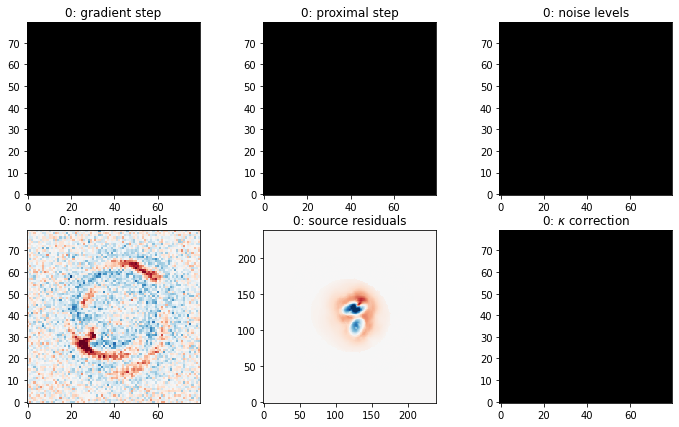

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in multiply


ValueError: x dimension of z must have same number of elements as x

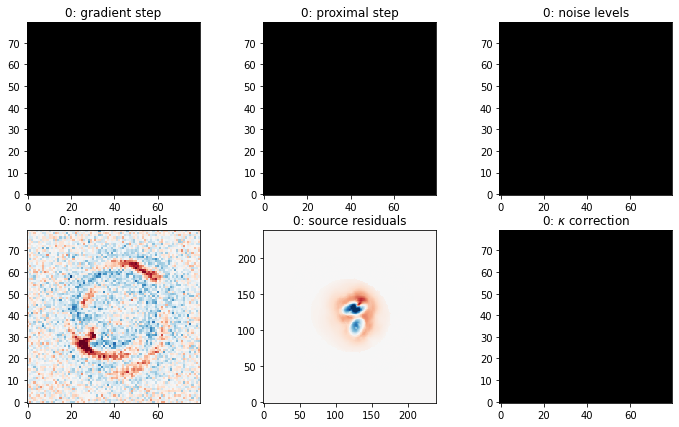

In [32]:
#residuals_perfect = background_rms * np.random.randn(num_pix, num_pix)

thresholds = [1e3, 1e3]
pot_corr, pot_corr_list, loss_list \
    = solve_for_potential_correction(data_class_ss, lens_model_class, kwargs_lens, source_estim_ss_smooth, 
                                     thresholds, min_threshold_source=10, step_size=1./0.98, 
                                     auto_noise_levels=False, num_iter=10,
                                     filter_on_inverse=False, force_positivity=False)

print(loss_list)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.set_title("Potential corrections")
im = ax.imshow(pot_corr, origin='lower', cmap='viridis')
nice_colorbar(im)
ax = axes[1]
ax.set_title("Loss history")
ax.plot(loss_list)
plt.show()

In [ ]:
raise  # below is nothing really upt to date...

**EVERYTHING BELOW THIS IS NOT UP TO DATE (AS ON 17/12/20)**

In [ ]:
def lens_model_param2interpol(lensmodel, kwargslens):
    f_ = lensmodel.potential(ra_grid_pot, dec_grid_pot, kwargslens)
    f_x, f_y = lensmodel.alpha(ra_grid_pot, dec_grid_pot, kwargslens)
    #f_xx, f_xy, _, f_yy = lensmodel.hessian(ra_grid_pot, dec_grid_pot, kwargslens)
    lensmodel_interp = LensModel(['INTERPOL'])
    kwargslens_interp = [{
        'grid_interp_x': x_axis_pot, 'grid_interp_y': y_axis_pot, 
        'f_': a2i(f_), 'f_x': a2i(f_x), 'f_y': a2i(f_y),
        #'f_xx': a2i(f_xx), 'f_yy': a2i(f_yy), 'f_xy': a2i(f_xy),
    }]
    return lensmodel_interp, kwargslens_interp

def extract_lens_model_properties(lensmodel_smooth, kwargslens_smooth, lensmodel_interpol, kwargslens_interpol):
    diff = 1e-5   #delta_pix_pot
    psi_smooth   = lensmodel_smooth.potential(ra_grid_pot, dec_grid_pot, kwargslens_smooth)
    psi_final    = lensmodel_interpol.potential(ra_grid_pot, dec_grid_pot, kwargslens_interpol)
    alpha_smooth_xy = lensmodel_smooth.alpha(ra_grid_pot, dec_grid_pot, kwargslens_smooth)
    alpha_smooth = np.sqrt(alpha_smooth_xy[0]**2 + alpha_smooth_xy[1]**2)  # norm of deflection angle vector field
    alpha_final_xy  = lensmodel_interpol.alpha(ra_grid_pot, dec_grid_pot, kwargslens_interpol, diff=diff)
    alpha_final = np.sqrt(alpha_final_xy[0]**2 + alpha_final_xy[1]**2)     # norm of deflection angle vector field
    kappa_smooth = lensmodel_smooth.kappa(ra_grid_pot, dec_grid_pot, kwargslens_smooth)
    kappa_final  = lensmodel_interpol.kappa(ra_grid_pot, dec_grid_pot, kwargslens_interpol, diff=diff)
    return dict(psi_p=a2i(psi_smooth), psi=a2i(psi_final),
                alpha_p=a2i(alpha_smooth), alpha=a2i(alpha_final),
                kappa_p=a2i(kappa_smooth), kappa=a2i(kappa_final))
    
def solve_source_potential(dataclass, lensmodel_smooth, kwargslens_smooth, 
                           num_iter=30, num_iter_pot=30,
                           init_threshold_pot=1e40, min_threshold_pot=None, min_threshold_pot_inner=None,
                           display_evolution=False):
    if min_threshold_pot is None:
        decrease_threshold_pot = False
    else:
        decrease_threshold_pot = True
    
    # convert parametric mass profile to pixelated profile
    lensmodel_pix, kwargslens_pix = lens_model_param2interpol(lensmodel_smooth, kwargslens_smooth)
   
    if display_evolution:
        #plt.ion()
        fig, axes = plt.subplots(1, 2)
    
    red_chi2_list = []
    threshold_pot_i = init_threshold_pot
    for i in tqdm.tqdm(range(num_iter)):
        # 1) solve for the source light
        source_results = solve_for_source(dataclass, lensmodel_pix, kwargslens_pix, num_iter=num_iter_source, 
                                          verbose=False, display_results=False)
        s_i = source_results[2]
        
        # 2) get the residuals (data - model)
        solver_i = source_results[3]
        model_i = solver_i.image_model(unconvolved=False)
        delta_d_i = model_i - dataclass.data
        red_chi2_list.append(solver_i.best_fit_reduced_chi2)
        
        # TEST:
        #delta_d_i = np.median(delta_d_i) * np.ones_like(model_i) # * np.random.randn(*model_i.shape)
        
        # 3) solve for the potential correction
        pot_results = solve_for_potential_correction(dataclass, lensmodel_pix, kwargslens_pix, s_i,
                                                     init_threshold=threshold_pot_i,
                                                     min_threshold=min_threshold_pot_inner, 
                                                     num_iter=num_iter_pot, num_iter_source=num_iter_source)
        delta_psi_i = pot_results[0]
        
        if display_evolution:
            axes[0].set_title(f"{i} | {threshold_pot_i:.1e} | {delta_psi_i.min():.1e}, {delta_psi_i.max():.1e}")
            axes[0].imshow(delta_psi_i, origin='lower')
            axes[1].set_title(f"{i} | {delta_d_i.min():.1e}, {delta_d_i.max():.1e}")
            axes[1].imshow(delta_d_i / np.sqrt(dataclass.C_D), origin='lower', vmin=-6, vmax=6, cmap=cmap_residuals)
            #fig.canvas.draw_idle()
            #fig.canvas.flush_events()
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        # 4) correct the potential
        lensmodel_pix, kwargslens_pix = correct_potential(delta_psi_i, lensmodel_pix, kwargslens_pix)
        
        # 5) update the threshold for potential
        if decrease_threshold_pot:
            threshold_pot_i = util.exponential_decrease(threshold_pot_i, init_threshold_pot, 
                                                        min_threshold_pot, num_iter, 5)
        
        # 6) do this again
    
    if display_evolution:
        plt.close()
    
    # final proper reconstruction at fixed mass and display summary
    source_results_final = solve_for_source(dataclass, lensmodel_pix, kwargslens_pix, num_iter=num_iter_source, 
                                            verbose=True, display_results=True)
    solver_final = source_results_final[3]
    #source_final = solver_final.source_model
    #model_final = solver_final.image_model(unconvolved=False)
    #red_res_final = solver_final.reduced_residuals_model
    
    source_final = source_results_final[2]
    lens_model_props = extract_lens_model_properties(lensmodel_smooth, kwargslens_smooth, lensmodel_pix, kwargslens_pix)

    return source_final, lens_model_props, np.array(red_chi2_list)


#### Run the above alternating algorithm

In [ ]:
kwargs_pixpot = {
    'num_iter': 10, 
    'num_iter_source': 20, 
    'num_iter_pot': 20,
    'init_threshold_pot': 1e10, 
    'min_threshold_pot': None,
    'min_threshold_pot_inner': None,
}

source_final, lens_model_properties, red_chi2s \
    = solve_source_potential(data_class_ss, lens_model_class, kwargs_lens, 
                             display_evolution=True, **kwargs_pixpot)

#### Display evolution of image plane reduced $\chi^2$

In [ ]:
plt.plot(range(num_iter_all), red_chi2s)
plt.xlabel("iterations")
plt.ylabel(r"$\chi^2_{\nu}$")
plt.title(r"image reduced $\chi^2$", fontsize=16)
plt.show()

#### Compare source light with the one from initial smooth mass model

In [ ]:
fig = SolverPlotter.plot_source_residuals_comparison(source_sim_comp,
                                                     [source_estim_ss, source_estim_ss_smooth, source_final],
                                                     ['with true lens model', 'before potential correction', 'after potential correction'],
                                                     vmin_res=-0.2, vmax_res=0.2)
plt.show()

#### Display the pixelated convergence corrected

In [ ]:
potential_param = lens_model_properties['psi_p']
potential_final = lens_model_properties['psi']
pot_corr_final = potential_final - potential_param

# get centers of the maps (https://stackoverflow.com/questions/30180241/numpy-get-the-column-and-row-index-of-the-minimum-value-of-a-2d-array)
cy_truth, cx_truth = divmod(pot_corr_truth.argmin(), pot_corr_truth.shape[1])
print(cx_truth, cy_truth)
cy_final, cx_final = divmod(pot_corr_final.argmin(), pot_corr_final.shape[1])
print(cx_final, cy_final)

plt.figure(figsize=(16, 3.5))
ax = plt.subplot(1, 3, 1)
ax.set_title(r"true potential correction $\delta \psi$")
pot_corr_truth_masked = pot_corr_truth * likelihood_mask
im = ax.imshow(pot_corr_truth_masked, origin='lower')
ax.plot([cx_truth], [cy_truth], marker='*', color='white', markersize=10, alpha=0.5)
nice_colorbar(im)
ax = plt.subplot(1, 3, 2)
ax.set_title(r"model potential correction $\delta \psi$")
pot_corr_final_masked = pot_corr_final * likelihood_mask
im = ax.imshow(pot_corr_final_masked, origin='lower')
ax.plot([cx_final], [cy_final], marker='.', color='white', markersize=12, alpha=0.5)
nice_colorbar(im)
ax = plt.subplot(1, 3, 3)
ax.set_title(r"truth - model")
diff_masked = (pot_corr_truth - pot_corr_final) * likelihood_mask
im = ax.imshow(diff_masked, origin='lower', cmap='RdBu_r', vmin=-0.02, vmax=0.02)
ax.plot([cx_truth], [cy_truth], marker='*', color='black', markersize=10, alpha=0.5)
ax.plot([cx_final], [cy_final], marker='.', color='black', markersize=12, alpha=0.5)
nice_colorbar(im)
plt.show()

#### Display deflection and convergence maps

In [ ]:
deflection_param = lens_model_properties['alpha_p']
deflection_final = lens_model_properties['alpha']
convergence_param = lens_model_properties['kappa_p']
convergence_final = lens_model_properties['kappa']

deflection_truth  = pixelated_deflection(lens_model_class_ss, kwargs_lens_ss)
convergence_truth = pixelated_convergence(lens_model_class_ss, kwargs_lens_ss)

print(f"total projected mass within image: M_smooth = {np.sum(convergence_param):.2e} | M_corr = {np.sum(convergence_final):.2e}")

plt.figure(figsize=(20, 7))

ax = plt.subplot(2, 4, 1)
ax.set_title("smooth deflection field (vector norm)")
im = ax.imshow(deflection_param, origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 4, 2)
ax.set_title("true deflection field (vector norm)")
im = ax.imshow(deflection_truth, origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 4, 3)
ax.set_title("corrected deflection field (vector norm)")
im = ax.imshow(deflection_final, origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 4, 4)
ax.set_title("truth - model")
im = ax.imshow(deflection_truth - deflection_final, origin='lower', cmap='RdBu_r')
nice_colorbar(im)

ax = plt.subplot(2, 4, 5)
ax.set_title("smooth convergence (log10)")
im = ax.imshow(np.log10(convergence_param), origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 4, 6)
ax.set_title("true convergence (log10)")
im = ax.imshow(np.log10(convergence_truth), origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 4, 7)
ax.set_title("corrected convergence (log10)")
im = ax.imshow(np.log10(convergence_final), origin='lower')
nice_colorbar(im)
ax = plt.subplot(2, 4, 8)
ax.set_title("truth - model")
im = ax.imshow(np.log10(convergence_truth - convergence_final), origin='lower', cmap='RdBu_r')
nice_colorbar(im)
plt.show()